In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
from os.path import join, isfile
from os import listdir
from functools import partial

import glam as gb

%load_ext autoreload
%autoreload 2

/Users/moltaire/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Example 3: Parameter Recovery

When performing model-based analyses of behaviour that include the interpretation of parameter estimates, or comparisons of parameter estimates between groups or conditions, the researcher should be confident that the estimates obtained from a given estimation procedure are adequate. This means that they should correspond, as closely as possible, to the true, data generating parameters. The researcher should therefore test, if the model’s parameters can be identified using the data set at hand. If, for example, the observed data can be reproduced similarly well by the model, using multiple different sets of parameters, then the obtained parameter estimates could be different from the true parameters and one should be very cautious interpreting parameter estimates (e.g., concluding that one group has a stronger gaze bias than another).
While previous analyses indicated that the GLAM’s parameters can be recovered to a satisfying degree, the parameters’ recoverability also depends on specific features of the data set the model is fitted to.
The most obvious feature of a data set that influences recoverability of model parameters is the number of data points included. This refers primarily to the number of trials. For hierarchical models, the precision with which group level estimates can be estimated also depends on the number of individuals per group.
Additional features that vary between data sets and that can influence the precision with which parameter estimates can be estimated are the observed distribution of gaze between alternatives (I imagine that gamma estimates can be less precise when gaze is distributed equally across alternatives), the distribution of item values (there might be value distributions / sets of values, where model predictions between parameter sets diverge more than others, therefore making parameters easier to be identified) or the number of items in each trial (no idea how this would influence parameter estimation). 

## General Intuition

The general intuition of a parameter recovery analysis is to first generate a synthetic data set from a model using a set of *known* parameters, and then fitting the model to the synthetic data. Finally, the estimated parameters can be compared to the *known generating* parameters. If they match to a satisfying degree, the parameters were *recovered* successfully. Ideally, the synthetic data set used for the recovery closely resembles the actual empirical `data`, to which the model is supposed to be applied, in its core features (e.g., number of data points, behavioural characteristics like response time distributions, accuracy, etc.).

### Simulation of data set (suppose this is the data obtained experimentally)

In [4]:
data_model = gb.GLAM()

parameters = dict(v=dict(mu=0.000075, sd=0.000025, bounds=(0.00001, 0.0002)),
                  gamma=dict(mu=0.1, sd=0.3, bounds=(-10, 1)),
                  s=dict(mu=0.008, sd=0.001, bounds=(0.003, 0.014)),
                  tau=dict(mu=1, sd=0.1, bounds=(0.5, 1.5)))

data_model.simulate_group(kind='hierarchical',
                          n_individuals=20,
                          n_trials=100,
                          n_items=3,
                          parameters=parameters,
                          error_weight=0.05,
                          error_range=(0, 5000),
                          value_range=(1, 7),
                          seed=1)

data = data_model.data

## Example Recovery

To demonstrate the procedure of a basic parameter recovery analysis using GLAMbox, suppose we have collected and loaded a data set called data. In the first step, we perform basic parameter estimation as in the previous examples:

In [5]:
hglam = gb.GLAM(data=data)
hglam.make_model(kind='hierarchical')
hglam.fit(method='MCMC', draws=5000, tune=5000, chains=4, cores=4, seed=2)

Generating hierarchical model for 20 subjects...
Fitting 1 model(s) using MCMC...
  Fitting model 1 of 1...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [tau_sd]
>Metropolis: [tau_mu]
>Metropolis: [s]
>Metropolis: [s_sd]
>Metropolis: [s_mu]
>Metropolis: [gamma]
>Metropolis: [gamma_sd]
>Metropolis: [gamma_mu]
>Metropolis: [v]
>Metropolis: [v_sd]
>Metropolis: [v_mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [04:24<00:00, 151.26draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/!\ Automatically setting parameter precision...


The next step is to create a synthetic, model-generated data set using the model parameters estimated from the empirical data, together with the empirically observed stimulus and gaze data. Setting`n_repeats` to 1 results in a data set of the same size as the observed one:

In [9]:
hglam.predict(n_repeats=1)
synthetic = hglam.prediction

  1%|          | 12/2000 [00:00<00:17, 116.09it/s]

Generating predictions for 2000 trials (1 repeats each)...


100%|██████████| 2000/2000 [00:16<00:00, 119.64it/s]


This data set should resemble the empirically observed data closely. Next, we create a new model instance, attach the synthetic data, build a hierarchical model and re-estimate its parameters:

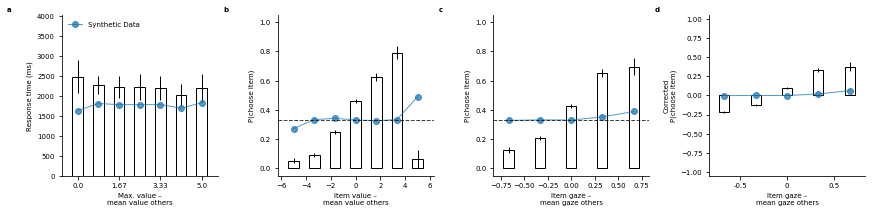

In [14]:
gb.plots.absolute_fit_aggregate(data, line_data=[synthetic], line_labels=['Synthetic Data']);

In [15]:
hglam_rec = gb.GLAM(data=synthetic)
hglam_rec.make_model(kind='hierarchical')
hglam_rec.fit(method='MCMC', draws=5000, tune=5000, cores=4, chains=4, seed=3)

Generating hierarchical model for 20 subjects...
Fitting 1 model(s) using MCMC...
  Fitting model 1 of 1...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [tau_sd]
>Metropolis: [tau_mu]
>Metropolis: [s]
>Metropolis: [s_sd]
>Metropolis: [s_mu]
>Metropolis: [gamma]
>Metropolis: [gamma_sd]
>Metropolis: [gamma_mu]
>Metropolis: [v]
>Metropolis: [v_sd]
>Metropolis: [v_mu]
Sampling 4 chains: 100%|██████████| 40000/40000 [04:29<00:00, 148.45draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/!\ Automatically setting parameter precision...


Finally, the recovered and generating parameters can be compared. If the recovered parameters do not align with the generating parameters, this indicates that model parameters cannot be identified given this specific data set. In this case, parameter estimates should not be interpreted, as the true parameters might be different from the obtained estimates.
If, on the other hand, generating and recovered parameters do align to a satisfying degree, the parameters have been recovered successfully. This increases confidence in that the parameters obtained from the empirical data are valid and can be interpreted.

xxx todo, this plot needs to be made nice, ideally using existing plot_node and plot_individual_node_comparison functions

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
def plot_recovery(model, true_parameters, parameters=['v', 'gamma' , 's', 'tau'],
                  figsize=(12, 4),
                  histogram_color='lightblue',
                  successcolor='green',
                  failcolor='red',
                  markersize=20,
                  linewidth=2):
    if model.type == 'hierarchical':
        n_rows = 2
        group_level = True
        i = 1
    elif model.type == 'individual':
        n_rows = 1
        group_level = False
        i = 0
    n_parameters = len(parameters)

    fig, axs = plt.subplots(n_rows, n_parameters, sharex='col', figsize=figsize)
        
    summary = pm.summary(model.trace[0])

    n_individuals = len(true_parameters[parameters[0]])
    
    df = pd.DataFrame(dict(subject=np.arange(n_individuals)))
    
    for p, parameter in enumerate(parameters):
        
        df[parameter + '_gen'] = true_parameters[parameter]
        df[parameter + '_rec'] = [summary.loc[parameter + '__{}_0'.format(i), 'mean']
                                  for i in range(n_individuals)]
        df[parameter + '_rec_hpd_lower'] = [summary.loc[parameter + '__{}_0'.format(i), 'hpd_2.5']
                                            for i in range(n_individuals)]
        df[parameter + '_rec_hpd_upper'] = [summary.loc[parameter + '__{}_0'.format(i), 'hpd_97.5']
                                            for i in range(n_individuals)]
        
        success = ((df[parameter + '_gen'] > df[parameter + '_rec_hpd_lower']) &
                   (df[parameter + '_gen'] < df[parameter + '_rec_hpd_upper'])).values.astype(int)
        color = np.array([failcolor, successcolor])[success]

        # Generating values
        axs[i, p].scatter(df[parameter + '_gen'],
                       np.arange(n_individuals),
                       marker='.',
                       color='black',
                       s=markersize,
                       zorder=2,
                       alpha=0.5)
        # Recovered values
        #  Mode
        axs[i, p].scatter(df[parameter + '_rec'],
                       np.arange(n_individuals),
                       marker='o',
                       facecolor='white',
                       linewidth=linewidth,
                       color=color,
                       s=markersize,
                       zorder=1)
        #  HPD
        axs[i, p].hlines(y=np.arange(n_individuals),
                      xmin=df[parameter + '_rec_hpd_lower'],
                      xmax=df[parameter + '_rec_hpd_upper'],
                      linewidth=linewidth,
                      color=color,
                      zorder=0)
    if group_level:
        for p, parameter in enumerate(parameters):
            pm.plot_posterior(model.trace[0],
                              varnames=[parameter + '_mu'],
                              ref_val=true_parameters[parameter].mean(),
                              ax=axs[0, p],
                              color=histogram_color)


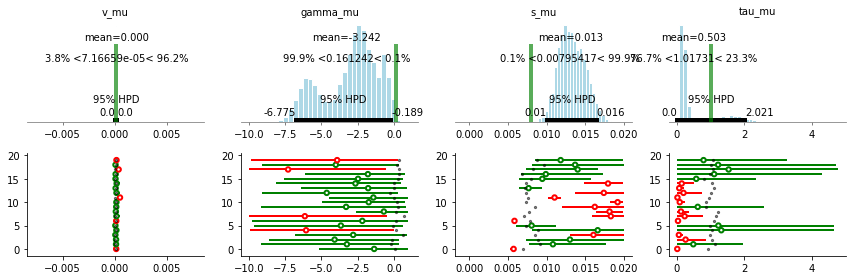

In [78]:
plot_recovery(hglam_rec, true_parameters)

In the example, all parameters could be recovered to a satisfying degree. Maximum a posteriori parameter estimates were close to the true generating parameters, on the level of the group (Fig. X, top row) and individual (Fig. X, bottom row).


# Conclusion

In this example, we demonstrated how to perform a basic parameter recovery for a given dataset. When successful, this increases confidence that the parameters can be identified with the given data set and that the obtained parameter estimates are the true generating parameters.
